# PyData Global 2021 Workshop <br>_Assessing and mitigating unfairness in AI Systems<br>_

---
Tutorial: 
- *Manojit Nandi* 
<br>

Panel: 
- Moderator: *Michael Madaio*
- Panelist: *Triveni Gandhi*, *Hanna Wallach*, *Kristen Laird*

Fairness in AI systems is an interdisciplinary field of research and practice that aims to understand and address some of the negative impacts of AI systems on society. In this workshop, we will walk through the process of assessing and mitigating fairness-related harms in the context of the U.S. health care system using *Fairlearn*.

# **Introduction of Fairlearn**


### [Fairlearn](https://fairlearn.org)

Fairlearn is an open-source, community-driven project to help data scientists improve fairness of AI systems. It includes:

* A Python library for fairness assessment and improvement (fairness metrics, mitigation algorithms, plotting, etc.)

* Educational resources covering organizational and technical processes for unfairness mitigation (user guide, case studies, Jupyter notebooks, etc.)

The project was started in 2018 at Microsoft Research. In 2021 it adopted neutral governance structure and since then it is completely community-driven.

# **Prepare environment**

## Import and set up packages

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.3f}".format)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    plot_roc_curve)
from sklearn import set_config

set_config(display="diagram")

In [4]:
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

In [5]:
from IPython import display
from datetime import date
import warnings

warnings.simplefilter("ignore")

# **Overview of fairness in AI systems**

## *Impact*, not *bias*

If you've heard anything about fairness in AI systems, you've probably heard this term *bias*. However, I will avoid using that term. The term "bias" is ambiguous in many cases and can mean different things to different communities.

Instead, let's focus on **impact**. We want to center the conversation on those who are harmed by these systems rather than centering on the AI systems themselves. Since we will be focusing on *harms*, we need a framework to discuss harms.

## Types of fairness-related harms

1. *Allocation harms*: Allocation harms occur when AI systems allocate resources or opportunities in a way that negatively impact people's lives.
    - ![Apple Credit Card](https://www.thesun.ie/wp-content/uploads/sites/3/2019/11/AD-COMPOSITE-Apple-Credit-Card.jpg?w=1500)

2. *Quality of Service harms*: Quality of service harms occur when an AI system performs worse for one group compared to others, even no opportunities are withheld.
    - ![Gender Shades](https://www.topbots.com/wp-content/uploads/2019/01/02_gender_shades_web.png)

3. *Representation harms*: Representation harms occur when an AI system stereotypes, demeans, or promotes antagonistic representation of users.
    - ![Google Photos](https://th.bing.com/th/id/R.4a779a0bfb2adb534f95437896e683db?rik=Lb8G2%2f3JRRl%2fZg&pid=ImgRaw&r=0)
    

# **Introduction to the health care scenario**

Our scenario builds on previous research that highlighted racial disparities in how health care resources are allocated in the U.S. ([Obermeyer et al., 2019](https://science.sciencemag.org/content/366/6464/447.full)).
Motivated by that work, in this tutorial we consider an automated system for recommending patients for _high-risk care management_ programs, which are described by Obermeyer et al. 2019 as follows:

> These programs seek to improve the care of patients with complex health needs by providing additional resources, including greater attention from trained providers, to help ensure that care is well coordinated. Most health systems use these programs as the cornerstone of population health management efforts, and they are widely considered effective at improving outcomes and satisfaction while reducing costs. [...] Because the programs are themselves expensive—with costs going toward teams of dedicated nurses, extra primary care appointment slots, and other scarce resources—**health systems rely extensively on algorithms to identify patients who will benefit the most.**

**Convenience restriction**

* In practice, the modeling of health needs would use large data sets covering a wide range of diagnoses. In this tutorial, we will work with a [publicly available clinical dataset](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that focuses on _diabetic patients only_ ([Strack et al., 2014](https://www.hindawi.com/journals/bmri/2014/781670/)).

## Dataset and task

We will be working with a clincial dataset of hospital re-admissions over a ten-year period (1998-2008) for diabetic patients across 130 different hospitals in the US. Each record represents the hospital admission records for a patient diagnosed with diabetes whose stay lasted one to fourteen days.

The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

We would like to develop a classification model, which decides whether the patients should be suggested to their primary care physicians for an enrollment into the high-risk care management program. The positive prediction will mean recommendation into the care program.

**Decision point: Task definition**

* A hospital **readmission within 30 days** can be viewed as a proxy that the patients needed more assistance at the release time, so it will be the label we wish to predict.

* Because of the class imbalance, we will be measuring our performance via **balanced accuracy**. Another key performance consideration is how many patients are recommended for care, metric we refer to as **selection rate**.

Ideally, health care professionals would be involved in both designing and using the model, including formalizing the task definition. 


## Fairness considerations

* _Which groups are most likely to be disproportionately negatively affected?_ Previous work suggests that groups with different race and ethnicity can be differently affected.

* _What are the harms?_ The key harms here are allocation harms. In particular, false negatives, i.e., don't recommend somebody who will be readmitted.

* _How should we measure those harms?_


# Task definition and dataset characteristics

Two critical decisions when desiging an AI system are
1. how we define the machine learning task
2. what dataset we use to train our models

These choices are often intertwined, because the dataset is often a convenience dataset, based on availability, which leads to a specific choice of label and performance metric (that's also the case in our scenario).

In this part of the tutorial, we first load the dataset, and then we examine it for a variety of fairness issues:
1. sample sizes of different demographic groups, and in particular different racial groups
2. appropriateness of our choice of label (readmission within 30 days)

Besides dataset characteristics, one additional aspect of dataset fairness is whether the data was collected in a manner that respects the autonomy of individuals in the dataset.

The dataset characteristics can be systematically documented through the **datasheets** practice. By documenting our understanding of the dataset, we communicate any concerns we have about the data and highlight downstream issues that may arise during the model training, evaluation and deployment.



## Load the dataset


We next load the dataset and review the meaning of its columns.


In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/fairlearn/talks/main/2021_scipy_tutorial/data/diabetic_preprocessed.csv")

In [7]:
df.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days
0,Caucasian,Female,30 years or younger,Other,Referral,1,Other,41,0,1,...,No,No,False,False,False,False,False,NO,0,0
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3,Missing,59,0,18,...,Ch,Yes,False,False,False,False,False,>30,1,0
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2,Missing,11,5,13,...,No,Yes,False,False,False,True,True,NO,0,0
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2,Missing,44,1,16,...,Ch,Yes,False,False,False,False,False,NO,0,0
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,Missing,51,0,8,...,Ch,Yes,False,False,False,False,False,NO,0,0


The columns contain mostly boolean and categorical data (including age and various test results), with just the following exceptions: `time_in_hospital`, `num_lab_procedures`, `num_procedures`, `num_medications`, `number_diagnoses`.


|features| description|
|---|---|
| race, gender, age | demographic features |
| medicare, medicaid | insurance information |
| admission_source_id | emergency, referral, or other |
| had_emergency, had_inpatient_days,<br>had_outpatient_days | hospital visits in prior year |
| medical_specialty | admitting physician's specialty |
| time_in_hospital, num_lab_procedures,<br>num_procedures, num_medications,<br>primary_diagnosis, number_diagnoses,<br>max_glu_serum, A1Cresult, insulin<br>change, diabetesMed | description of the hospital visit<br> |
| discharge_disposition_id | discharched to home or not |
| readmitted, readmit_binary,<br>readmit_30_days | readmission information |




In [8]:
# Show the values of all binary and categorical features
categorical_values = {}
for col in df:
  if col not in {'time_in_hospital', 'num_lab_procedures',
                 'num_procedures', 'num_medications', 'number_diagnoses'}:
    categorical_values[col] = pd.Series(df[col].value_counts().index.values)
categorical_values_df = pd.DataFrame(categorical_values).fillna('')
categorical_values_df.T

,0,1,2,3,4,5
race,Caucasian,AfricanAmerican,Unknown,Hispanic,Other,Asian
gender,Female,Male,Unknown/Invalid,,,
age,Over 60 years,30-60 years,30 years or younger,,,
discharge_disposition_id,Discharged to Home,Other,,,,
admission_source_id,Emergency,Referral,Other,,,
medical_specialty,Missing,Other,InternalMedicine,Emergency/Trauma,Family/GeneralPractice,Cardiology
primary_diagnosis,Other,Respiratory Issues,Diabetes,Genitourinary Issues,Musculoskeletal Issues,
max_glu_serum,None,Norm,>200,>300,,
A1Cresult,None,>8,Norm,>7,,
insulin,No,Steady,Down,Up,,


We mark all categorical features: 

In [9]:
categorical_features = [
    "race",
    "gender",
    "age",
    "discharge_disposition_id",
    "admission_source_id",
    "medical_specialty",
    "primary_diagnosis",
    "max_glu_serum",
    "A1Cresult",
    "insulin",
    "change",
    "diabetesMed",
    "readmitted"
]

In [10]:
for col_name in categorical_features:
  df[col_name] = df[col_name].astype("category")

## Group sample sizes 

From the perspective of fairness assessment, a key data characteristic is the sample size of groups with respect to which we conduct fairness assessment.

Small sample sizes have two implications:

* **assessment**: the impacts of the AI system on smaller groups are harder to assess, because due to fewer data points we have a much larger uncertainty (error bars) in our estimates

* **model training**: fewer training data points mean that our model fails to appropriately capture any data patterns specific to smaller groups, which means that its predictive performance on these groups could be worse

Let's examine the sample sizes of the groups according to `race`:



In [11]:
df["race"].value_counts()

Caucasian          76099
AfricanAmerican    19210
Unknown             2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

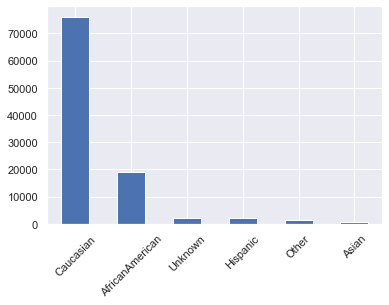

In [12]:
df["race"].value_counts().plot(kind='bar', rot=45);

Normalized as frequencies:

In [13]:
df["race"].value_counts(normalize=True)

Caucasian         0.748
AfricanAmerican   0.189
Unknown           0.022
Hispanic          0.020
Other             0.015
Asian             0.006
Name: race, dtype: float64

In our dataset, our patients are predominantly *Caucasian* (75%). The next largest racial group is *AfricanAmerican*, making up 19% of the patients. The remaining race categories (including *Unknown*) compose only 6% of the data.

We also examine the dataset composition by `gender`:

In [14]:
df["gender"].value_counts() # counts

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [15]:
df["gender"].value_counts(normalize=True) # frequencies

Female            0.538
Male              0.462
Unknown/Invalid   0.000
Name: gender, dtype: float64

Gender is in our case effectively binary (and we have no further information how it was operationalized), with both *Female* represented at 54% and *Male* represented at 46%. There are only 3 samples annotated as *Unknown/Invalid*.

### Decision point: How do we address smaller group sizes?

When the data set lacks coverage of certain groups, it means that we will not be able to reliably assess any fairness-related issues. There are three interventions (which could be carried out in a combination):

* **collect more data**: collect more data for groups with fewer samples
* **buckets**: merge some of the groups
* **drop small groups**

The choice of strategy depends on our existing understanding of which groups are at the greatest risk of a harm. In particular, pooling the groups with widely different risks could mask the extent of harms. We generally caution against dropping small groups as this leads to the representational harm of erasure.

If any groups are merged or dropped, these decisions should be annotated / explained (in the datasheet or other documentation process).

In our case, we will:

* merge the three smallest race groups *Asian*, *Hispanic*, *Other* (similar to [Strack et al., 2014](https://www.hindawi.com/journals/bmri/2014/781670/)), but also retain the original groups for auxiliary assessments

* drop the gender group *Unknown/Invalid*, because the sample size is so small that no meaningful fairness assessment is possible

In [16]:
# drop gender group Unknown/Invalid
df = df.query("gender != 'Unknown/Invalid'")

# retain the original race as race_all, and merge Asian+Hispanic+Other 
df["race_all"] = df["race"]
df["race"] = df["race"].replace({"Asian": "Other", "Hispanic": "Other"})

## Label imbalance



Now that we have established the validity of our label, we will check frequency of its values in our data. The frequency of different labels is an important descriptive characteristic in classification settings for several reasons:

* some classification algorithms and performance measures might not work well with data sets with extreme class imbalance
* in binary classification settings, our ability to evaluate error is often driven by the size of the smaller of the two classes (again, the smaller the sample the larger the uncertainty in estimates)
* label imbalance may exacerbate the problems due to smaller group sizes in fairness assessment



Let's check how many samples in our data are labeled as positive and how many as negative.

In [17]:
df["readmit_30_days"].value_counts() # counts

0    90406
1    11357
Name: readmit_30_days, dtype: int64

In [18]:
df["readmit_30_days"].value_counts(normalize=True) # frequencies

0   0.888
1   0.112
Name: readmit_30_days, dtype: float64

As we can see, the target label is heavily skewed towards the patients not being readmitted within 30 days. In our dataset, only 11% of patients were readmitted within 30 days.

Since there are fewer positive examples, we expect that we will have a much larger uncertainty (error bars) in our estimates of *false negative rates* (FNR), compared with *false positive rates* (FPR). This means that there will be larger differences between training FNR and test FNR, even if there is no overfitting, simply because of the smaller sample sizes. 

Our target metric is *balanced error rate*, which is the average of FPR and FNR. The value of this metric is robust to different frequencies of positives and negatives. However, since half of the metric is contributed by FNR, we expect the uncertainty in balanced error values to behave similarly to the uncertainty of FNR.

Now, let's examine how much the label frequencies vary within each group defined by `race`:

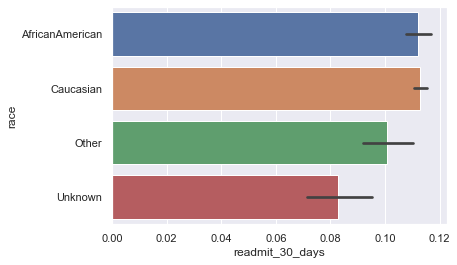

In [19]:
sns.barplot(x="readmit_30_days", y="race", data=df, ci=95);

We see the rate of *30-day readmission* is similar for the *AfricanAmerican* and *Caucasian* groups, but appears smaller for *Other* and smallest for *Unknown* (this is consistent with an overall lower rate of hospital visits in the prior year). The smaller sample size of the *Other* and *Unknown* groups mean that there is more uncertainty around the estimate for these two groups.

# Training the initial model

We next train a classification model to predict our target variable (readmission within 30 days) while optimizing balanced accuracy.

What kind of model should we train? Deep neural nets? Random forests? Logistic regression?

There are a variety of considerations. We highlight two:

* **Interpretability.** Interpretability is tightly linked with questions of fairness. There are several reasons why it is important to have interpretable models that are open to the stakeholder scrutiny:
  * It allows discovery of fairness issues that were not discovered by the data science team.
  * It provides a path toward recourse for those that are affected by the model.
  * It allows for a *face validity* check, a "sniff test", by experts to verify that the model "makes sense" (at the face value). While this step is subjective, it is really important when the model is applied to different populations than those on which the assessment was conducted.

* **Model expressiveness.** How well can the model separate positive examples from negative examples? How well can it do so given the available dataset size? Can it do so across all groups or does it need to trade off performance on one group against performance on another group?

Some additional considerations are training time (this impacts the ability to iterate), familiarity (this impacts the ability to fine tune and debug), and carbon footprint (this impacts the Earth climate both directly and indirectly by normalizing unnecessarily heavy workloads).

### Decision point: Model type

We will use a logistic regression model. Our reasoning:

* **Interpretability**. Logistic models over a small number of variables (as used here) are highly interpretable in the sense that stakeholders can simulate them easily.

* **Model expressiveness**. Logistic regression predictions are described by a linear weighting of the feature values. The concern might be that this is too simple. The previous work by [Strack et al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/), which also used a logistic model to predict readmission rates concluded that a slightly more expressive model might be useful (their analysis uncovered 8 pairwise interactions that were significant, see their Table 5).

## Prepare training and test datasets

As we mentioned in the task definition, our target variable is **readmission within 30 days**, and our sensitive feature for the purposes of fairness assessment is **race**.


In [20]:
target_variable = "readmit_30_days"
demographic = ["race", "gender"]
sensitive = ["race"]
# If multiple sensitive features are chosen, the rest of the script considers intersectional groups.

In [21]:
Y, A = df.loc[:, target_variable], df.loc[:, sensitive]

We next drop the features that we don't want to use in our model and expand the categorical features into 0/1 indicators ("dummies").

In [22]:
X = pd.get_dummies(df.drop(columns=[
    "race",
    "race_all",
    "discharge_disposition_id",
    "readmitted",
    "readmit_binary",
    "readmit_30_days"
]))

In [23]:
X.head() # sanity check

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,...,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,1,41,0,1,1,False,False,False,False,False,...,1,0,0,1,0,0,0,1,1,0
1,3,59,0,18,9,False,False,False,False,False,...,1,0,0,0,0,1,1,0,0,1
2,2,11,5,13,6,False,False,False,True,True,...,1,0,0,1,0,0,0,1,0,1
3,2,44,1,16,7,False,False,False,False,False,...,1,0,0,0,0,1,1,0,0,1
4,1,51,0,8,5,False,False,False,False,False,...,1,0,0,0,1,0,1,0,0,1


We split our data into a training and test portion. The test portion will be used to evaluate our performance metric (i.e., balanced accuracy), but also for fairness assessment. The split is half/half for training and test to ensure that we have sufficient sample sizes for fairness assessment.

In [24]:
random_seed = 445
np.random.seed(random_seed)

In [25]:
X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    df,
    test_size=0.50,
    stratify=Y,
    random_state=random_seed
)

Our performance metric is **balanced accuracy**, so for the purposes of training (but not evaluation!) we will resample the data set, so that it has the same number of positive and negative examples. This means that we can use estimators that optimize standard accuracy (although some estimators allow the use us importance weights).


Because we are downsampling the number of negative examples, we create a training dataset with a significantly lower number of data points. For more complex machine learning models, this lower number of training data points may affect the model's accuracy.

In [26]:
def resample_dataset(X_train, Y_train, A_train):

  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  A_train = A_train.loc[balanced_ids, :]
  return X_train, Y_train, A_train

In [27]:
X_train_bal, Y_train_bal, A_train_bal = resample_dataset(X_train, Y_train, A_train)

## Train the model

We train a logistic regression model and save its predictions on test data for analysis.

In [28]:
unmitigated_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=1000))
])

In [29]:
unmitigated_pipeline.fit(X_train_bal, Y_train_bal)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

In [30]:
Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:,1]
Y_pred = unmitigated_pipeline.predict(X_test)

Check model performance on test data.

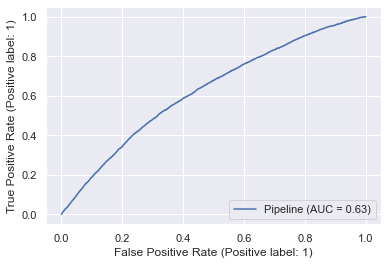

In [31]:
# Plot ROC curve of probabilistic predictions
plot_roc_curve(unmitigated_pipeline, X_test, Y_test);

In [32]:
# Show balanced accuracy rate of the 0/1 predictions
balanced_accuracy_score(Y_test, Y_pred)

0.5937900251950625

As we see, the performance of the model is well above the performance of a coin flip (whose performance would be 0.5 in both cases), albeit it is quite far from a perfect classifier (whose performance would be 1.0 in both cases).


# **Fairness assessment**

## Measuring fairness-related harms





The goal of fairness assessment is to answer the question: *Which groups of people may be disproportionately negatively impacted by an AI system and in what ways?*

The steps of the assesment are as follows:
1. Identify harms
2. Identify the groups that might be harmed
3. Quantify harms
4. Compare quantified harms across the groups

We next examine these four steps in more detail.

### 1. Identify harms

For example, in a system for screening job applications, qualified candidates that are automatically rejected experience an allocation harm. In a speech-to-text transcription system, high error rates constitute harm in the quality of service.

**In the health care scenario**, the patients that would benefit from a care management program, but are not recommended for it experience an allocation harm. In the context of the classification scenario these are **FALSE NEGATIVES**.

### 2. Identify the groups that might be harmed

In most applications, we consider demographic groups including historically marginalized groups (e.g., based on gender, race, ethnicity). We should also consider groups that are relevant to a particular application. For example, for speech-to-text transcription, groups based on the regional dialect or being a native or a non-native speaker.

It is also important to consider group intersections, for example, in addition to considering groups according to gender and groups according to race, it is also important to consider their intersections (e.g., Black women, Latinx nonbinary people, etc.).

**In the health care scenario**, based on the previous work, we focus on groups defined by **RACE**.

### 3. Quantify harms

Define metrics that quantify harms or benefits:

* In job screening scenario, we need to quantify the number of candidates that are classified as "negative" (not recommended for the job), but whose true label is "positive" (they are qualified). One possible metric is the **false negative rate**: fraction of qualified candidates that are screened out.

* In speech-to-text scenario, the harm could be measured by **word error rate**, number of mistakes in a transcript divided by the overall number of words.

* **In the health care scenario**, we could consider two metrics for quantifying harms / benefits:
  * **false negative rate**: fraction of patients that are readmitted within 30 days, but that are not recommended for the care management program; this quantifies harm
  * **selection rate**: overall fraction of patients that are recommended for the care management program (regardless of whether they are readmittted with 30 days or no); this quantifies benefit; here the assumption is that all patients benefit similarly from the extra care.

There are several reasons for including selection rate in addition to false negative rate. We would like to monitor how the benefits are allocated, focusing on groups that might be disadvantaged. Another reason is to get extra robustness in our assessement, because our measure (i.e., readmission within 30 days) is only an imperfect measure of our construct (who is most likely to benefit from the care management program). The auxiliary metrics, like selection rate, may alert us to large disparities in how the benefit is allocated, and allow us to catch issues that we might have missed.


### 4. Compare quantified harms across the groups

The workhorse of fairness assessment are _disaggregated metrics_, which are **metrics evaluated on slices of data**. For example, to measure harms due to errors, we would begin by evaluating the errors on each slice of the data that corresponds to a group we identified in Step 2.
If some of the groups are seeing much larger errors than other groups, we would flag this as a fairness harm.

To summarize the disparities in errors (or other metrics), we may want to report quantities such as the **difference** or **ratio** of the metric values between the best and the worst slice. In settings where the goal is to guarantee certain minimum quality of service (such as speech recognition), it is also meaningful to report the **worst performance** across all considered groups.



For example, when comparing false negative rate across groups defined by race, we may summarize our findings with a table like the following:

| | false negative rate<br>(FNR) |
|---|---|
| AfricanAmerican | 0.43 |
| Caucasian | 0.44 |
| Other | 0.52 |
| Unknown | 0.67 |
| | |
|_largest difference_| 0.24 &nbsp;&nbsp;(best is 0.0)|
|_smallest ratio_| 0.64 &nbsp;&nbsp;(best is 1.0)|
|_maximum_<br>_(worst-case) FNR_|0.67|

## Fairness assessment with `MetricFrame`

Fairlearn provides the data structure called `MetricFrame` to enable evaluation of disaggregated metrics. We will show how to use a `MetricFrame` object to assess the trained `LogisticRegression` classifier for potential fairness-related harms.



In [33]:
# In its simplest form MetricFrame takes four arguments:
#    metric_function with signature metric_function(y_true, y_pred)
#    y_true: array of labels
#    y_pred: array of predictions
#    sensitive_features: array of sensitive feature values

mf1 = MetricFrame(metrics=false_negative_rate,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# The disaggregated metrics are stored in a pandas Series mf1.by_group:

mf1.by_group

race
AfricanAmerican   0.428
Caucasian         0.442
Other             0.523
Unknown           0.670
Name: false_negative_rate, dtype: object

In [34]:
# The largest difference, smallest ratio and worst-case performance are accessed as
#   mf1.difference(), mf1.ratio(), mf1.group_max()

print(f"difference: {mf1.difference():.3}\n"
      f"ratio: {mf1.ratio():.3}\n"
      f"max across groups: {mf1.group_max():.3}")

difference: 0.242
ratio: 0.639
max across groups: 0.67


In [35]:
# You can also evaluate multiple metrics by providing a dictionary

metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# The disaggregated metrics are then stored in a pandas DataFrame:

metricframe_unmitigated.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.400,0.428,0.597
Caucasian,0.391,0.442,0.594
Other,0.328,0.523,0.584
Unknown,0.264,0.670,0.536


In [36]:
# The largest difference, smallest ratio, and the maximum and minimum values
# across the groups are then all pandas Series, for example:

metricframe_unmitigated.difference()

selection_rate        0.137
false_negative_rate   0.242
balanced_accuracy     0.061
dtype: object

In [37]:
# You'll probably want to view them transposed:

pd.DataFrame({'difference': metricframe_unmitigated.difference(),
              'ratio': metricframe_unmitigated.ratio(),
              'group_min': metricframe_unmitigated.group_min(),
              'group_max': metricframe_unmitigated.group_max()}).T

,selection_rate,false_negative_rate,balanced_accuracy
difference,0.137,0.242,0.061
ratio,0.659,0.639,0.897
group_min,0.264,0.428,0.536
group_max,0.400,0.670,0.597


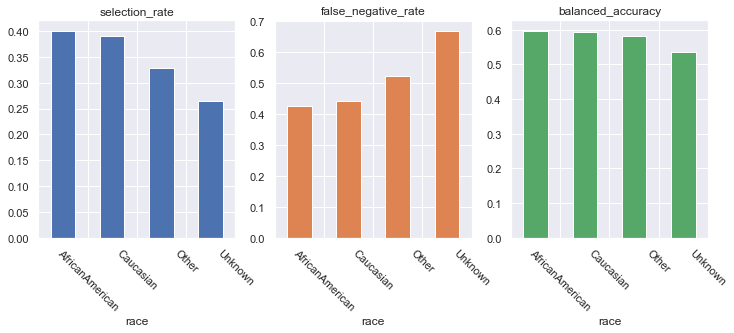

In [38]:
# You can also easily plot all of the metrics using DataFrame plotting capabilities

metricframe_unmitigated.by_group.plot.bar(subplots=True, layout= [1,3], figsize=(12, 4),
                      legend=False, rot=-45, position=1.5);

According to the above bar chart, it seems that the group *Unknown* is selected for the care management program less often than other groups as reflected by the selection rate. Also this group experiences the largest false negative rate, so a larger fraction of group members that are likely to benefit from the care management program are not selected. Finally, the balanced accuracy on this group is also the lowest.



We observe disparity, even though we did not include race in our model. There's a variety of reasons why such disparities may occur. It could be due to representational issues (i.e., not enough instances per group), or because the feature distribution itself differs across groups (i.e., different relationship between features and target variable, obvious example would be people with darker skin in facial recognition systems, but can be much more subtle). Real-world applications often exhibit both kinds of issues at the same time.



---


# **Mitigating fairness-related harms in ML models**

We have found that the logistic regression predictor leads to a large difference in false negative rates between the groups. We next look at **algorithmic mitigation strategies** of this fairness issue (and similar ones).

*Note that while we currently focus on the training stage of the AI lifecycle mitigation should not be limited to this stage. In fact, we have already discussed mitigation strategies that are applicable at the task definition stage (e.g., checking for construct validity) and data collection stage (e.g., collecting more data).*

Within the model training stage, mitigation may occur at different steps relative to model training:

* **Preprocessing**: A mitigation algorithm is applied to transform the input data to the training algorithm; for example, some strategies seek to remove and dependence between the input features and sensitive features.

* **At training time**: The model is trained by an (optimization) algorithm that seeks to satisfy fairness constraints.

* **Postprocessing**: The output of a trained model is transformed to mitigate fairness issues; for example, the predicted probability of readmission is thresholded according to a group-specific threshold.

We will now dive into two algorithms: a postprocessing approach and a reductions approach (which is a training-time algorithm). Both of them are in fact **meta-algorithms** in the sense that they act as wrappers around *any* standard (fairness-unaware) machine learning algorithms. This makes them quite versatile in practice.


## Postprocessing with `ThresholdOptimizer`

**Postprocessing** techniques are a class of unfairness-mitigation algorithms that take an already trained model and a dataset as an input and seek to fit a transformation function to model's outputs to satisfy some (group) fairness constraint(s). They might be the only feasible unfairness mitigation approach when developers cannot influence training of the model, due to practical reasons or due to security or privacy.


Here we use the `ThresholdOptimizer` algorithm from Fairlearn, which follows the approach of [Hardt, Price, and Srebro (2016)](https://arxiv.org/abs/1610.02413).

`ThresholdOptimizer` takes in an exisiting (possibly pre-fit) machine learning model whose predictions act as a scoring function and identifies a separate thrceshold for each group in order to optimize some specified objective metric (such as **balanced accuracy**) subject to specified fairness constraints (such as **false negative rate parity**). Thus, the resulting classifier is just a suitably thresholded version of the underlying machinelearning model.

The constraint **false negative rate parity** requires that all the groups have equal values of false negative rate.



To instatiate our `ThresholdOptimizer`, we pass in:

*   An existing `estimator` that we wish to threshold. 
*   The fairness `constraints` we want to satisfy.
*   The `objective` metric we want to maximize.



In [39]:
# Now we instantite ThresholdOptimizer with the logistic regression estimator
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

In order to use the `ThresholdOptimizer`, we need access to the sensitive features **both during training time and once it's deployed**.

In [40]:
postprocess_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=Pipeline(steps=[('preprocessing',
                                              StandardScaler()),
                                             ('logistic_regression',
                                              LogisticRegression(max_iter=1000))]),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

In [41]:
# Record and evaluate the output of the trained ThresholdOptimizer on test data

Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess,
    sensitive_features=A_test
)

We can now inspect how the metric values differ between the postprocessed model and the unmitigated model:

In [42]:
pd.concat([metricframe_unmitigated.by_group,
           metricframe_postprocess.by_group],
           keys=['Unmitigated', 'ThresholdOptimizer'],
           axis=1)

Unmitigated                                        \
                selection_rate false_negative_rate balanced_accuracy   
race                                                                   
AfricanAmerican          0.400               0.428             0.597   
Caucasian                0.391               0.442             0.594   
Other                    0.328               0.523             0.584   
Unknown                  0.264               0.670             0.536   

                ThresholdOptimizer                                        
                    selection_rate false_negative_rate balanced_accuracy  
race                                                                      
AfricanAmerican              0.427               0.400             0.598  
Caucasian                    0.451               0.389             0.590  
Other                        0.412               0.455             0.574  
Unknown                      0.459               0.436             0.557

We next zoom in on differences between the largest and the smallest metric values:

In [43]:
pd.concat([metricframe_unmitigated.difference(),
           metricframe_postprocess.difference()],
          keys=['Unmitigated: difference', 'ThresholdOptimizer: difference'],
          axis=1).T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated: difference,0.137,0.242,0.061
ThresholdOptimizer: difference,0.047,0.066,0.041


As we see, `ThresholdOptimizer` was able to substantially decrease the difference between the values of false negative rate.

Finally, we visualize the disagregated statistics:

array([[<AxesSubplot:title={'center':'selection_rate'}, xlabel='race'>,
        <AxesSubplot:title={'center':'false_negative_rate'}, xlabel='race'>,
        <AxesSubplot:title={'center':'balanced_accuracy'}, xlabel='race'>]],
      dtype=object)

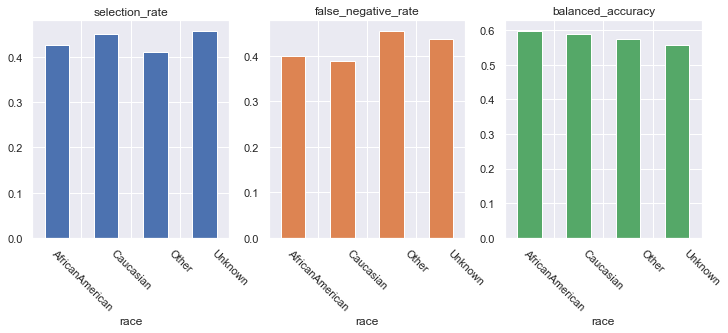

In [44]:
metricframe_postprocess.by_group.plot.bar(subplots=True, layout=[1,3], figsize=(12, 4), legend=False, rot=-45, position=1.5)

## Reductions approach with `ExponentiatedGradient`

With the `ThresholdOptimizer`, we took a fairness-unaware model and transformed the model's decision boundary to satisfy our fairness constraints. One limitation of `ThresholdOptimizer` is that it needs access to the sensitive features at deployment time.

In this section, we will show how to use the _reductions_ approach of [Agarwal et. al (2018)](https://arxiv.org/abs/1803.02453) to obtain a model that satisfies the fairness constraints, but does not need access to sensitive features at deployment time.

Terminology "reductions" refers to another kind of a wrapper approach, which instead of wrapping an already trained model, wraps any standard classification or regression algorithm, such as 
`LogisticRegression`. In other words, an input to a reduction algorithm is an object that supports training on any provided (weighted) dataset. In addition, a reduction algorithm receives a data set that includes sensitive features. The goal, like with post-processing, is to optimize a performance metric (such as classification accuracy) subject to fairness constraints (such as an upper bound on differences between false negative rates).

The main reduction algorithm algorithm in Fairlearn is `ExponentiatedGradient`. It creates a sequence of reweighted datasets and retrains the wrapped model on each of them. The 
retraining process is guaranteed to find a model that satisfies the fairness constraints while optimizing the performance metric.

The model returned by `ExponentiatedGradient` consists of several inner models, returned by the wrapped estimator. At deployment time, `ExponentiatedGradient` randomizes among these models according to a specific probability weights.

To instantiate an `ExponentiatedGradient` model, we pass in two parameters:

*   A base `estimator` (an object that supports training)
*   Fairness `constraints` (an object of type `Moment`).

The constraints supported by `ExponentiatedGradient` are more general than those supported by `ThresholdOptimizer`. For example, rather than requiring that false negative rates be equal, it is possible to specify the maxium allowed difference or ratio between the largest and the smallest value.


In [45]:
expgrad_est = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000, random_state=random_seed),
    constraints=TruePositiveRateParity(difference_bound=0.02)
)

The constraints above are expressed for the true positive parity, they require that the difference between the largest and the smallest true positive rate (TPR) across all groups be at most 0.02. Since false negative rate (FNR) is equal to 1-TPR, this is equivalent to requiring that the difference between the largest and smallest FNR be at most 0.02.

In [46]:
# Fit the exponentiated gradient model
expgrad_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.TruePositiveRateParity object at 0x0000023B3D8478C8>,
                      estimator=LogisticRegression(max_iter=1000,
                                                   random_state=445),
                      nu=0.002303268819590091)

Similarly to `ThresholdOptimizer` the predictions of `ExponentiatedGradient` models are randomized. If we want to assure reproducible results, we can pass  `random_state` to the `predict` function. 

In [47]:
# Record and evaluate predictions on test data

Y_pred_reductions = expgrad_est.predict(X_test, random_state=random_seed)
metricframe_reductions = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_reductions,
    sensitive_features=A_test
)
metricframe_reductions.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.408,0.424,0.595
Caucasian,0.398,0.445,0.588
Other,0.338,0.518,0.580
Unknown,0.344,0.574,0.545


In [48]:
# Evaluate the difference between the largest and smallest value of each metric
metricframe_reductions.difference()

selection_rate        0.070
false_negative_rate   0.150
balanced_accuracy     0.050
dtype: object

While there is a decrease in the false negative rate difference from the unmitigated model, this decrease is not as substantial as with `ThresholdOptimizer`. Note, however, that `ThresholdOptimizer` was able to use the sensitive feature (i.e., race) at deployment time.

### Explore individual predictors

During the training process, the `ExponentiatedGradient` algorithm iteratively trains multiple inner models on a reweighted training dataset. The algorithm stores each of these predictors and then randomizes among them at deployment time.

In many applications, the randomization is undesirable, and also using multiple inner models can pose issues for interpretability. However, the inner models that `ExponentiatedGradient` relies on span a variety of fairness-accuracy trade-offs, and they could be considered for stand-alone deployment: addressing the randomization and interpretability issues, while possibly offering additional flexibility thanks to a variety of trade-offs. 

In this section explore the performance of the individual predictors learned by the `ExponentiatedGradient` algorithm. First, note that since the base estimator was `LogisticRegression` all these predictors are different logistic regression models:

In [49]:
predictors = expgrad_est.predictors_
predictors

0    LogisticRegression(max_iter=1000, random_state...
1    LogisticRegression(max_iter=1000, random_state...
2    LogisticRegression(max_iter=1000, random_state...
3    LogisticRegression(max_iter=1000, random_state...
4    LogisticRegression(max_iter=1000, random_state...
5    LogisticRegression(max_iter=1000, random_state...
6    LogisticRegression(max_iter=1000, random_state...
7    LogisticRegression(max_iter=1000, random_state...
8    LogisticRegression(max_iter=1000, random_state...
dtype: object

In [50]:
# Collect predictions by all predictors and calculate balanced error
# as well as the false negative difference for all of them

sweep_preds = [clf.predict(X_test) for clf in predictors]
balanced_error_sweep = [1-balanced_accuracy_score(Y_test, Y_sweep) for Y_sweep in sweep_preds]
fnr_diff_sweep = [false_negative_rate_difference(Y_test, Y_sweep, sensitive_features=A_test) for Y_sweep in sweep_preds]

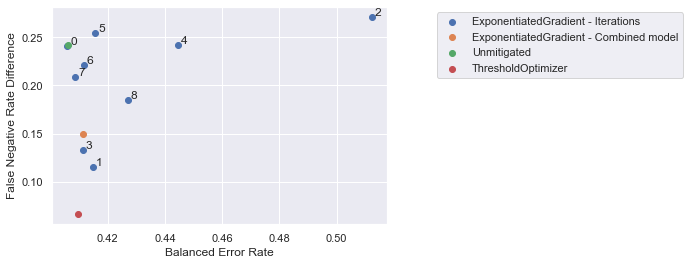

In [51]:
# Show the balanced error / fnr difference values of all predictors on a raster plot  

plt.scatter(balanced_error_sweep, fnr_diff_sweep, label="ExponentiatedGradient - Iterations")
for i in range(len(predictors)):
  plt.annotate(str(i), xy=(balanced_error_sweep[i]+0.001, fnr_diff_sweep[i]+0.001))

# Also include in the plot the combined ExponentiatedGradient model
# as well as the three previously fitted models

plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_reductions),
            false_negative_rate_difference(Y_test, Y_pred_reductions, sensitive_features=A_test),
            label="ExponentiatedGradient - Combined model")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred),
            false_negative_rate_difference(Y_test, Y_pred, sensitive_features=A_test),
            label="Unmitigated")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_postprocess),
            false_negative_rate_difference(Y_test, Y_pred_postprocess, sensitive_features=A_test),
            label="ThresholdOptimizer")

plt.xlabel("Balanced Error Rate")
plt.ylabel("False Negative Rate Difference")
plt.legend(bbox_to_anchor=(1.9,1))
plt.show()

## Comparing performance of different techniques

Now we have covered two different class of techniques for mitigating the fairness-related harms we found in our fairness-unaware model. In this section, we will compare the performance of the models we trained above across our key metrics.

#### Model performance - by group

In [52]:
def plot_technique_comparison(mf_dict, metric):
  """
  Plots a specified metric for a given dictionary of MetricFrames.
  """
  mf_dict = {k:v.by_group[metric] for (k,v) in mf_dict.items()}
  comparison_df = pd.DataFrame.from_dict(mf_dict)
  comparison_df.plot.bar(figsize=(12, 6), legend=False)
  plt.title(metric)
  plt.xticks(rotation=0, ha='center');
  plt.legend(bbox_to_anchor=(1.01,1), loc='upper left')

In [53]:
test_dict = {
    "Reductions": metricframe_reductions,
    "Unmitigated": metricframe_unmitigated,
    "Postprocessing": metricframe_postprocess
}

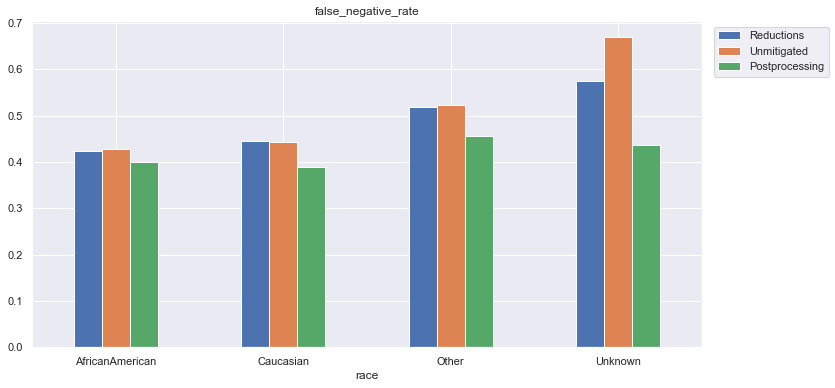

In [54]:
plot_technique_comparison(test_dict, "false_negative_rate")

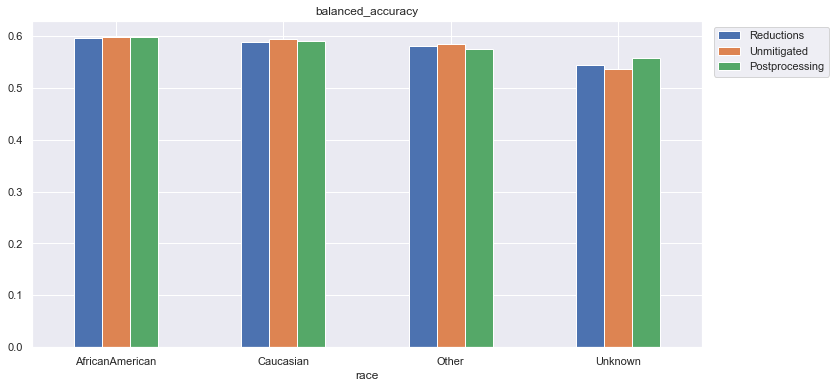

In [55]:
plot_technique_comparison(test_dict, "balanced_accuracy")



#### Model performance - overall

In [56]:
overall_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.overall,
    "Postprocessing": metricframe_postprocess.overall,
    "Reductions": metricframe_reductions.overall
})

In [57]:
overall_df.T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated,0.387,0.446,0.594
Postprocessing,0.445,0.395,0.591
Reductions,0.396,0.446,0.589


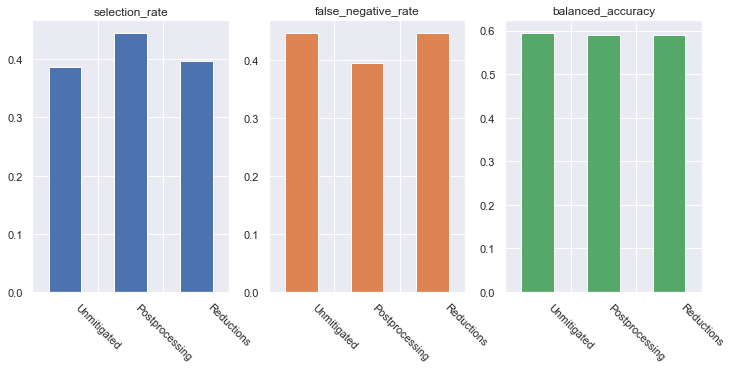

In [58]:
overall_df.transpose().plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);

### Access to sensitive features





*   The `ThresholdOptimizer` model requires access to the sensitive features during BOTH training time and once deployed. If you do not have access to the sensitive features once the model is deployed, you will not be able to use the `ThresholdOptimizer`.
*   The `ExponentiatedGradient` model requires access to the sensitive features ONLY during training time. 




# Discussion and conclusion

In this tutorial we have explored in depth a health care scenario through all stages of the AI lifecycle except the model deployment stage. We have seen how fairness-related harms can arise at the stage of task definition, data collection, model training, and model evaluation. 

Once the model is deployed, it is important to continue monitoring the key metrics to assess any performance difference as well as the potential for fairness related harms. As you learn more about how the model is used, you may need to revise the fairness metrics, update the model, consider additional sensitive features, update the task definition, or collect new data.

Although we used a variety of software tools, fairness is a sociotechnical challenge, so mitigations cannot be purely technical, and need to be supported by processes and practices, including government regulation and organizational incentives.

If you would like to learn more about fairness of AI systems, or to contribute to Fairlearn, we welcome you to join our community. Fairlearn is built and maintained by contributors with a variety of backgrounds and expertise.

Further resources can also be found [on our website](https://fairlearn.org/main/user_guide/further_resources.html).

## Attribution

This tutorial is adapted from the **Fairness in AI Systems**: *From Social Context to Practice using Fairlearn* given at *SciPy 2021*. The tutorial is avaliable online on [GitHub](https://github.com/fairlearn/talks/tree/main/2021_scipy_tutorial).